# Classification with Imbalanced Data

## setup

In [1]:
import pandas as pd
import numpy as np # linear algebra
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

In [2]:
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, SCORERS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, LeaveOneOut

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

import graphviz

from sklearn.utils import resample

In [3]:
def score_prediction(y_test, y_pred):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Credit Card Fraud dataset

source: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [5]:
df = pd.read_csv('input/creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


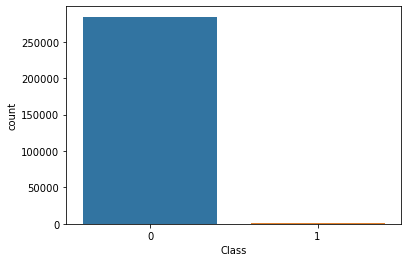

In [6]:
sns.countplot(x=df['Class']);

In [7]:
good = df[df['Class']==0]
fraud = df[df['Class']==1]

print(f'Fraudulent transactions: {len(fraud):,}; Good transactions: {len(good):,}')

Fraudulent transactions: 492; Good transactions: 284,315


### Full sample

In [8]:
#spliting the data for target and features
X = df.drop(columns=['Class'], axis=1)
y = df['Class'] #.astype('int')

In [9]:
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size = 0.7, random_state=42, stratify=y) # 
print(X_train.shape, X_test.shape)
print(f'Ratio of fraudulent transactions in train dataset: {y_train.mean()}, in test dataset: {y_test.mean()}')

(199364, 30) (85443, 30)
Ratio of fraudulent transactions in train dataset: 0.0017254870488152324, in test dataset: 0.0017321489179921118


#### Naive prediction: all zeros in test dataset

In [10]:
y_pred = np.zeros(y_test.shape)
score_prediction(y_test, y_pred)

Accuracy:  0.998
Precision: 0.000
Recall:    0.000
F1:        0.000


/Users/giedrius/anaconda3/envs/scipy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Conclusion: Accuracy is a very poor metric in inbalanced data

In [11]:
clf_tree = DecisionTreeClassifier(min_samples_split=7)
model_tree = clf_tree.fit(X_train, y_train)

In [12]:
y_pred = model_tree.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.999
Precision: 0.800
Recall:    0.703
F1:        0.748


In [13]:
def plot_classification(y_true, y_pred):
    target_names = ['Valid', 'Fraud']
    labels_names = [0, 1] 
    print(classification_report(y_true, y_pred,labels=labels_names, target_names=target_names))    
    cm = confusion_matrix(y_true, y_pred,labels=labels_names)  #, normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()

              precision    recall  f1-score   support

       Valid       1.00      1.00      1.00     85295
       Fraud       0.80      0.70      0.75       148

    accuracy                           1.00     85443
   macro avg       0.90      0.85      0.87     85443
weighted avg       1.00      1.00      1.00     85443



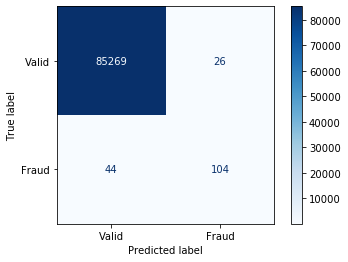

In [14]:
plot_classification(y_test, y_pred)

#### Conclusion: Recall is bad, as 30% of fraud cases are not caught - bad for business

### What happens as we try to balance out the data?

#### Simple under-sampling

In [15]:
df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 1]
size_minor = len(df_minority)

y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                   replace=False,    # sample with replacement
                   n_samples=size_minor,    # to match majority class
                   random_state=42)  # reproducible results

X_down_train = pd.concat([df_minority, df_majority_downsampled])
# print(X_down_train.shape)

y_majority_downsampled = y_majority[df_majority_downsampled.index]
y_down_train = pd.concat([y_minority, y_majority_downsampled])
# y_down_train.value_counts()

# sns.countplot(y_down_train);

In [16]:
clf_tree_down = DecisionTreeClassifier(min_samples_split=7)
model_tree_down = clf_tree_down.fit(X_down_train, y_down_train)
y_pred = model_tree_down.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.890
Precision: 0.014
Recall:    0.885
F1:        0.027


              precision    recall  f1-score   support

       Valid       1.00      0.89      0.94     85295
       Fraud       0.01      0.89      0.03       148

    accuracy                           0.89     85443
   macro avg       0.51      0.89      0.48     85443
weighted avg       1.00      0.89      0.94     85443



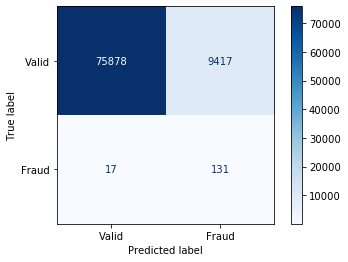

In [17]:
plot_classification(y_test, y_pred)

#### Recall is better, but precision is very bad, as many valid transactions are predicted to be fraud - bad customer experience

### Test model accuracy (using F1-score as a metric) as amount of data increases

In [19]:
# Let's try doubling the amount of data for majority class

df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 1]

y_majority = y_train[y_train == 0]
y_minority = y_train[y_train == 1]
    
for size_minor in [344, 700, 1500, 3000, 6000, 12000, 24000, 48000, 96000]:
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                   replace=False,    # sample with replacement
                   n_samples=size_minor,    # to match majority class
                   random_state=42)  # reproducible results

    X_down_train = pd.concat([df_minority, df_majority_downsampled])

    y_majority_downsampled = y_majority[df_majority_downsampled.index]
    y_down_train = pd.concat([y_minority, y_majority_downsampled])
    
    clf_tree_down = DecisionTreeClassifier(min_samples_split=7)
    model_tree_down = clf_tree_down.fit(X_down_train, y_down_train)
    y_pred = model_tree_down.predict(X_test)
    print(f'Training sample size: {len(X_down_train):,}, F1-score: {f1_score(y_test, y_pred):.3f}, Precision: {precision_score(y_test, y_pred):.3f}, Recall: {recall_score(y_test, y_pred):.3f}')

Training sample size: 688, F1-score: 0.026, Precision: 0.013, Recall: 0.872
Training sample size: 1,044, F1-score: 0.061, Precision: 0.032, Recall: 0.845
Training sample size: 1,844, F1-score: 0.112, Precision: 0.060, Recall: 0.824
Training sample size: 3,344, F1-score: 0.147, Precision: 0.081, Recall: 0.818
Training sample size: 6,344, F1-score: 0.275, Precision: 0.165, Recall: 0.824
Training sample size: 12,344, F1-score: 0.359, Precision: 0.230, Recall: 0.818
Training sample size: 24,344, F1-score: 0.474, Precision: 0.341, Recall: 0.777
Training sample size: 48,344, F1-score: 0.617, Precision: 0.498, Recall: 0.811
Training sample size: 96,344, F1-score: 0.698, Precision: 0.647, Recall: 0.757


#### Conclusion: additional data increases f1-score, so we want to balance out the problem by not loosing relevant data